In [51]:
# Main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Scikit-learn: Models
from sklearn.linear_model import LinearRegression, LogisticRegression

# Scikit-learn: Testing and evaluation
from sklearn.metrics import (
    mean_squared_error, 
    r2_score
)
from sklearn.model_selection import (
    train_test_split, 
)



In [52]:
df = pd.read_csv('dataset/flights.csv')

In [53]:
df = ETL(df)

# ETL for regression

In [54]:
drop_features = [
    'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'FL_YEAR', 'DEP_TIME', 'ARR_TIME',
    'WHEELS_OFF', 'WHEELS_ON',
    'FL_MON', 'FL_DAY', 'CRS_ELAPSED_TIME',	'ACTUAL_ELAPSED_TIME'
]
df = df.drop(columns=drop_features, errors='ignore')

In [55]:
categorical_features = ['OP_CARRIER', 'ORIGIN', 'DEST', 'C_REASON','FL_DOW']

standard_features = [
    'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 
    'ACT_TO_CRS_RATIO', 'ARR_DELAY',
    'AIR_TIME', 'DISTANCE'
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = min_max_scaler.fit_transform(df[standard_features])

In [56]:
df = pd.get_dummies(df)

# Crea le colonne dummies per 'FL_DOW'
fl_dow_dummies = pd.get_dummies(df['FL_DOW'], prefix='FL_DOW')

# Aggiungi le nuove colonne dummies al DataFrame
df = pd.concat([df, fl_dow_dummies], axis=1)

# Se vuoi, puoi eliminare la colonna originale 'FL_DOW'
df = df.drop('FL_DOW', axis=1)


In [57]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,ACT_TO_CRS_RATIO,OP_CARRIER_9E,...,C_REASON_Not cancelled,C_REASON_Security,C_REASON_Weather,FL_DOW_0,FL_DOW_1,FL_DOW_2,FL_DOW_3,FL_DOW_4,FL_DOW_5,FL_DOW_6
0,0.120859,0.026432,0.008658,0.109530,0.0,0.0,0.093651,0.067447,0.160497,False,...,True,False,False,False,False,False,True,False,False,False
1,0.127607,0.057269,0.021645,0.120050,0.0,0.0,0.044444,0.020800,0.166327,False,...,True,False,False,False,False,False,True,False,False,False
2,0.119632,0.088106,0.017316,0.121287,0.0,0.0,0.363492,0.331785,0.197895,False,...,True,False,False,False,False,False,True,False,False,False
3,0.123313,0.057269,0.017316,0.109530,0.0,0.0,0.296825,0.265751,0.176896,False,...,True,False,False,False,False,False,True,False,False,False
4,0.120245,0.044053,0.030303,0.113243,0.0,0.0,0.179365,0.155695,0.183183,False,...,True,False,False,False,False,False,True,False,False,False


# Regression

In [58]:
y = df['ARR_DELAY']
x = df.drop(columns=['ARR_DELAY'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(95416, 766)
(23855, 766)
(95416,)
(23855,)


In [59]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [67]:
# Predizioni sui dati di test
y_pred = model.predict(x_test)

# Valutazione del modello
r2_score = model.score(x_train, y_train)

print("R^2 Score:", r2_score)
# Calcolare MSE e RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R^2 Score: 0.9731520740788926
RMSE: 68552793.98217154


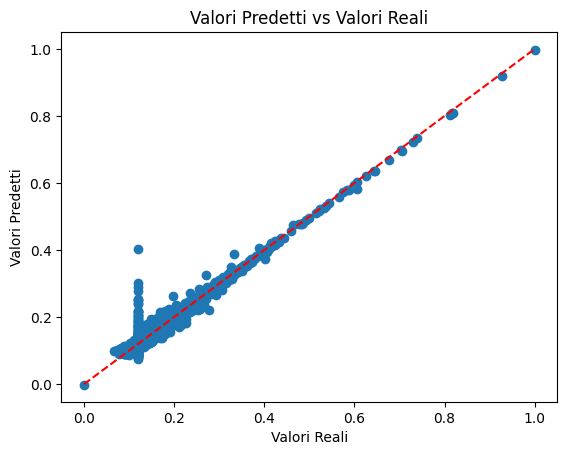

In [62]:
plt.scatter(y_train, y_pred)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Predetti vs Valori Reali')
plt.show()


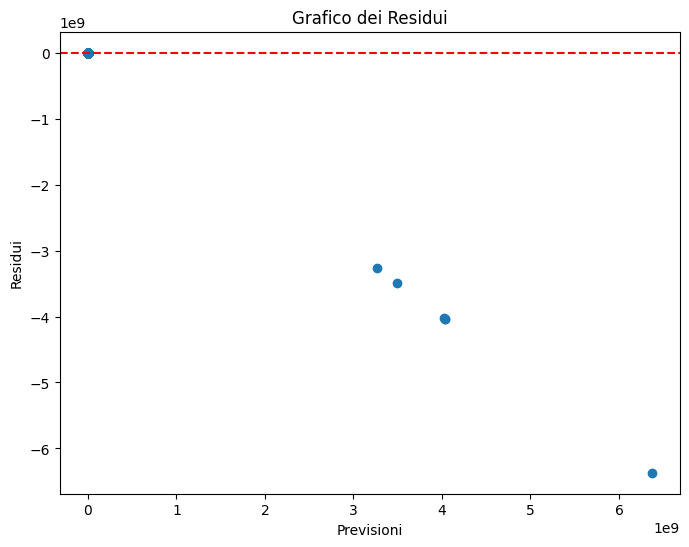

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsioni')
plt.ylabel('Residui')
plt.title('Grafico dei Residui')
plt.show()

MemoryError: Unable to allocate 251. TiB for an array with shape (34546239483839,) and data type float64

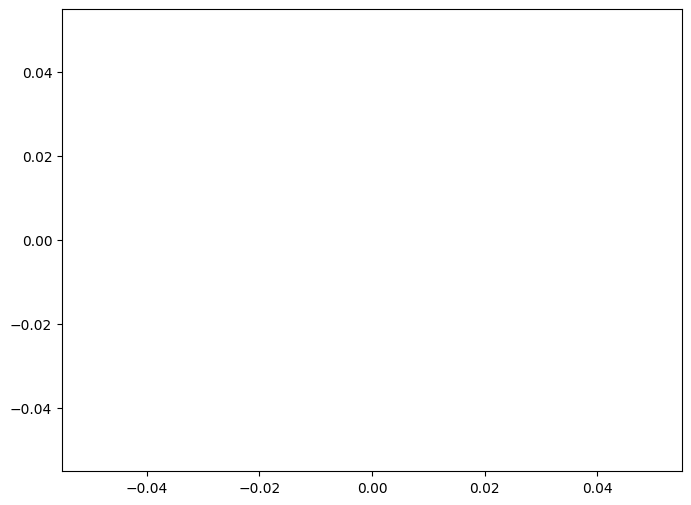

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Errori')
plt.title('Distribuzione degli Errori')
plt.show()

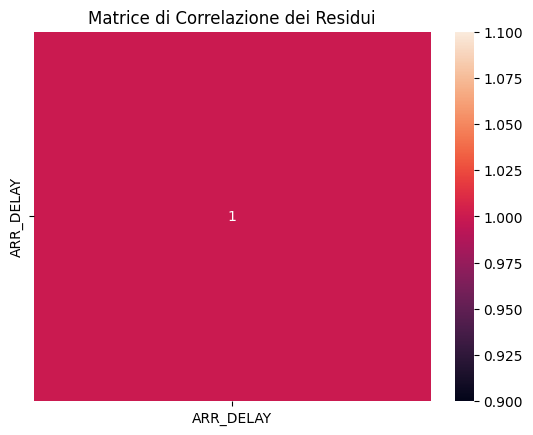

In [63]:
residuals = y_train - y_pred
residuals_df = pd.DataFrame(residuals)
correlation_matrix = residuals_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matrice di Correlazione dei Residui')
plt.show()
